### Loading of all the Python packages necessary to run this script

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import os
from scipy.signal import savgol_filter
from datetime import datetime
from FTIR_analyzer_fnc import computer,\
                            Rexp,\
                            subtract_one_spectrum,\
                            baseline_als,\
                            FTIR_plot,\
                            outlier_removal,\
                            find_peak_intensity,\
                            max_abs_finder,\
                            wn_selector,\
                            peak_fitting,\
                            derivative_tests,\
                            string_to_float,\
                            peak_finder_derivative,\
                            user_interactive_mode,\
                            user_answer,\
                            from_dict_to_df,\
                            plot_time_trends,\
                            period_average,\
                            psd_transform,\
                            SVD,\
                            MCR_fit,\
                            shape_check,\
                            MSC,\
                            convoluzione,\
                            CH4_removal

import warnings
warnings.filterwarnings('ignore')

## Settings and variables

##### Computer details:

* _**computer type**_ : windows or mac - it helps in defining the absolute path to find the files.
* _**computer_usrname**_ : the name of the account you are working under - necessary to define the absolute path
* _**path**_ : change the strings in the method according to where the files sit in your computer.

#####  Experiment details:

* _**folder**_: name of the folder where the .SPA and .CSV files are.
* _**keyword_file_name**_: Name of the series or common name of all the .CSV you want to read without extensions -  REQUIRED
* _**file_to_subtract**_: Usually it is you bare catalyst surface spectrum
* _**catalyst**_: catalyst name
* _**variable_OI**_: 'Time' or 'Temperature'. It is the variable you are changing during the experiment.
* _**T_min**_: None or int/float. it is the baseline temperature you used during the temperature programmed desorption. if None is selected and temperature is the variable of interest, the software defaults to 50 ℃.
* _**sampling**_: how often a spectrum was collected. If the variable of interest is time, express this value in _seconds_ (60, 300, ...). If the variable is the temperature, this parameter is the dT used between experiments. The software, at the moment, is only able to handle a constant dT. 
* _**unit_of_measure**_: s, min, h, days, C or K. It is important for plotting purposes.

In [2]:
##########  COMPUTER DETAILS ######################################
computer_type = 'mac' #'windows', 'mac'
computer_usrname = 'giada' 
########## EXPERIMENT DETAILS ######################################
folder = '20210927_MES-CH4_CZ14Ni2DI'#'folder_name'
keyword_file_name = '20210927_MES-CH4_CZ14Ni2DI'#'MeOH_N2_UV'
file_to_subtract = None # it has to be a unique identifier for the file you want to use as 'background'
catalyst = ' '

variable_OI = 'Time' # 'Time' or 'Temperature'
T_min = 50     # None, int or float
sampling = 30  #seconds or dT
unit_of_measure = 'min' # s, min, h, days, C

##### COMPUTER ABSOLUTE PATH #######
# change the strings in this method according to the absolute path in your computer    
path =  os.path.join(computer(computer_type),'Users',computer_usrname,'Desktop',\
                        'Demo_data', 'MES_Experiment',folder)
print(path)

/Users/giada/Georgia Institute of Technology/Williams, Olivia C - DOE IR/MES-CH4 modulation IR data/20210927_MES-CH4_CZ14Ni2DI


# Data Manipulation:
* _**remove_outliers**_: if set to *True* it removes spectra that contains clear artifacts due to some problems tha instrument sometimes may have. - when those artifacts are present, they are clear. it removes these artifacts either according to a minimum threshold for the standard deviation set by the user or using the average or median standard deviation of two consecutive spectra.
    - _stdv_value_: this parameter is ignored if remove_outliers is set to *False*.
* _**baseline_removal**_: *True* or *False*. If *True* it removes the baseline from the spectrum according to the algorithm reported by *Paul H. C. Eilers and Hans F.M. Boelens: Baseline Correction with Asymmetric Least Squares Smoothing* using *p = 0.05* and *$ \lambda = 10^6$*, p controls the asymmetry while λ the smoothness.
* _**shift_on_zero**_: *True* or *False*. If *True* it shifts all the spectra around absorbance zero by removing the absorbance value for the wavenumber at 2500 cm$^{-1}$. The wavenumber was chosen since it is the most unlike to have some molecule adsorbed.

##### Gas Phase contribution removal
CH$_4$ is used in this case but the code should work in principle for any gas phase contamination. The script is able to handle more than one contaminant but the present version is optimized for only 1 contaminat.
* _**gas_removal**_: *True* or *False*. if will remove the reference spectra of the gas if set to True.
* _**gas_file_name**_: 'file_name'. Unique identifier of the file.
* _**perform_MSC**_: *True* or *False*. MSC is a normalization technique used to compensate for light scattering effects and changes in path length. For more information read [here](https://www.osapublishing.org/as/abstract.cfm?uri=as-39-3-491) or [here](https://www.osapublishing.org/as/abstract.cfm?uri=as-42-7-1273) or [wikipedia](http://wiki.eigenvector.com/index.php?title=Advanced_Preprocessing:_Sample_Normalization#MSC_.28Multiplicative_Scatter_Correction.29)
* _**gas_contribution_range**_: list of lists or tuples. It needs to contain the range of interest for example: [(2700,3300)] if you need to remove the gas phase contribution from more than one spectral region it becomes [(a,b),(c,d),...]. If you don't want to remove only specific parts set this key to either None or [].
* _**weight_CH4_spectra**_: *True* or *False*. Set to True, if you want to evaluate the statistical weight for your gas phase contribution from a specific range and then apply it to the whole spectrum.
* _**visualize_CH4_removal**_: list of booleans or booleans. if True it will print the fitted gas phase contribution with respect to the experimental spectra and their difference for each time. Recommended as a False unless, something is odd and there is a need to check what is happening.

* _**gas_spectrum_path**_ : change the strings in the method according to where the files sit in your computer.

In [3]:
###########################################################
#           DATA MANIPULATIONS                            #
###########################################################
remove_outliers = False 
stdv_value= 'mean' #'mean' 'median' float
baseline_removal = False
shift_on_zero = False
### GAS CONTAMINANT REMOVAL ###
gas_removal = True
gas_file_name = '20210308_gas CH4'
perform_MSC = True
gas_contribution_range = [(2700,3300),(1400,1100)]
weight_CH4_spectra = False
visualize_CH4_removal = [False, False]

##### Absolute path of the folder containing the spectrum/a of the gas phase contribution(s) #######
# change the strings in this method according to the absolute path in your computer    
gas_spectrum_path = os.path.join(computer(computer_type),'Users',computer_usrname,\
                                 'Desktop','Demo_data','Contaminants')

# Spectra Subtraction:
* _**Subtraction**_: *True* or *False*. it alows to subtract two spectra from each other or one spectrum from a list of other spectra. The reference variable is the time on stream or temperature at which the spectrum is referred. if set to false all the following parameters will be ignored. 
    - _time_base_: it is an integer representing the time or temperature you want to subtract from the others.
    - _time_list_: list of time or temperature that you want to subtract from
    - _save_subtraction_csv_: if *True* saves the subtracted spectra as CSV files.

In [4]:
##############################################################
#            SPECTRA SUBTRACTION                            #
##############################################################
subtraction = False

time_base = 50.
time_list = [150.,200.] # [10,20,30,40,50,60,70,80,90]

save_subtraction_csv = False

# Plotting settings
* _**plots_xmin**_:  it represent the minimum wavenumber were there is sensitivity. It is used for plotting and for removing useless wavenumbers.
* _**interactive_plots**_: *True* or *False*, if *True* it is possible to interact with the plot in the notebook, zoom in and out as well as checking the wavenumber and intensity of a specific point. if *False* all the plots will be shown as images in the notebook.\
___________________________
The following three keys are important only for the plots Intensity or Area vs Time or Temperature. The plot Intensity vs Time/Temperature is produced by setting peak_finder to True while the pplot Area vs Time/Temperature is produced with peak_deconvolution set to True.
* _**smoothed_trends**_: *True* or *False*. If false it does not smooth the data.
* _**line**_ = None, '-','--','-.','.' It decides the line stile of the trends in the plot area vs Time/Temperature.
    - None = no line
    - '-' or 'solid' = solid line
    - '.' or 'dotted' = dotted line
    - '--' or ' dashed' = dashed line
    - '-.' or 'dashdot' = dashdotted line
* _**marker**_ = None, '*','.','o' ... It decides the line stile of the trends in the plot area vs Time/Temperature.
    - None = no marker
    - '*' = star
    - '.' = point
    - 'o' = circle
    - for more marker symbols check out [this page](https://matplotlib.org/stable/api/markers_api.html).


In [5]:
###########################################################
#          PLOTTING                                       #
###########################################################
plots_xmin = 1000. 
interactive_plots= False
##
smoothed_trends = True
line = '--'
marker = 'o'

# Peak Finder
* _**peak_finder**_: *True* or *False*. It relies on scipy.signal.peak_finder and it works by finding the maximum intensity. It is implemented by retrieve all the peaks at each time, selecting the time with the highest number of peaks detected and then optimizing the position of those peaks for each time. if set to *True* it allows to produce a plot with the peak labels printed on it.
    - *peak_height_threshold* = None, Int or Float -- The default value is 100 (this number is dividing the maximum intensity)
    - *peak_prominence* = None Int, or Float  -- The default is 0.01 (the higher the prominence the lower number of peaks will find) 
    - *peakwidth* = None, Int or float -- The default is 1, useful to increase if there is a noisy signal
    - *peak_rel_height* = None, Int or float -- The default is 0.3, it is the relative height of the peak\
    For more information on these 4 parameters: [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)
* _**visualize_optimized_max**_: *True* or *False*. if true it shows a plot with all the spectra and a marker on the position that peak has at each time.
* _**show_peak_trends**_: *True* or *False*. If *True* displays two plots showing the trend of the intensity and wavenumber with respect to the time or temperature.
* _**save_peak_trends**_: if *True* it saves the peak intensity trend at each time for the specific wavenumber in a CSV.
* _**show_label_plot**_: *True* or *False*. If *True* displays a plot of the spectra in an absorbance vs wavenumber plot showing the label of each peak. The position of such label is controlled by the lists reported in the next section called 'LABELED PLOT'.

In [6]:
###########################################################
#          PEAK INTENSITY MAXIMUM FINDER                  #
###########################################################
peak_finder = False
peak_height_threshold = None # default is 100 (this number is dividing the maximum intensity)
peak_prominence = 0.001 # default is 0.01 (the higher the lower number of peaks will find) 
peakwidth = None #  default is 1, useful to increase if there is a noisy signal
peak_rel_height = None # default is 0.3


visualize_optimized_max = True
show_peak_trends = False
save_peak_trends = True
show_label_plot = True

# Labeled Plot
* _**height1**_: list of floats controlling the height of the label with respect to its position on the plot in the range between 3050 and 2725 cm$^{-1}$
* _**align1**_ : list of strings ('center','right' or 'left') controlling the alignment of the label with respect to its position on the plot in the range between 3050 and 2725 cm$^{-1}$
* _**height2**_: list of floats controlling the height of the label with respect to its position on the plot in the range between 1800 and 1300 cm$^{-1}$
* _**align2**_ : list of strings ('center','right' or 'left') controlling the alignment of the label with respect to its position on the plot in the range between 1800 and 1300 cm$^{-1}$

In [7]:
###########################################################
#          LABEL PLOT PEAK NAME (wavenumber)              #
###########################################################
############### 4000 - 2500 cm-1 ################
# controls the height and the alignment of the text on the figure between 3050 and 2725
height1 =[0.5,0.55,0.6]*10 
align1 = ['left', 'center','right']*3
############### 2000 - 1300 cm-1 ################
# controls the height and the alignment of the text on the figure between 1800 and 1300
height2 = [ 0.6, 0.65 , 1.0,.25 ,0.028,0.05, 0.13,0.05, 0.15]*10 
align2 = ['center','center','center','center','right']*10



# Peak Fitting

* _**show_derivatives_preview**_: *True* or *False* - it shows two plots for each spectrum, on the left side there is the spectrum while on the right side it shows first and second derivatives 
______________________________________________________________________________________________________________
* _**fit_wn_min**_: minimum wavenumber to perform the peak fitting
* _**fit_wn_max**_: maximum wavenumber to perform the peak fitting
______________________________________________________________________________________________________________


* _**peak_deconvolution**_: *True* or *False*.
    - _derivative_peak_finder_: *True* or *False*. if *True* find the peak position to perform the peak fitting using the first and second derivative test
        * _user_check_: *True* or *False*. it allows the user to add or remove peak(s) to the one found by the algorithm.
    - _user_full_control_: *True* or *False*. it gives to the user the full control. The user decider what peaks to fit and they will be optimized for all the spectra at every time.
    - _peak_intensity_: *True* or *False*. use the maxima you found by using peak finder to do the peak fitting
\

* _**save_fit_output**_: *True* or *False*. If *True* it saves the dataframe as a CSV and the dictionary containing the data as a json.


In [8]:
show_derivatives_preview = False
#####################################################################
#        REGION TO DECONVOLUTE                                      #
#####################################################################
fit_wn_min = 2500
fit_wn_max = 3400
#####################################################################
#                  DECONVOLUTION                                    #
#####################################################################
peak_deconvolution = False
#################### OPTION 1 ######################################
derivative_peak_finder = False
user_check = False 
#################### OPTION 2 #######################################
user_full_control = True 
#################### OPTION 3 #######################################
peak_intensity = False

save_fit_output = True

# Peak Shape and Baseline  selection (Distribution Parameters)
if any of these parameters is set to *None*, the default values will be used to calculate each distribution. If only an integer or float is given, that number will be used to define all the distributions. 
* _**baseline_type**_: None, 'linear', 'polynomial', 'exponential'. If None is selected it defaults to 'exponential'.
* _**peak_shape**_: None, 'gaussian', 'lorentzian', 'voigt', 'pseudo-voigt', 'DoniachModel', 'SkewedVoigtModel', 'SplitLorentzianModel', 'ExponentialGaussianModel', 'SkewedGaussianModel'. if None is selected, it defaults to pseudo-voigt. \
     - _**peak_center_min**_: None, integer, float or list. The default value removed from the peak center value is resolution*4 (16).
    - _**peak_center_max**_: None, integer, float or list. The default value added to the peak center value is resolution*4 (16).
    - _**area_min**_: None, integer, float or list. The Default value is 0 and it represent the minimum value allowed for the curve.
    - _**area_max**_: None, integer, float or list. IThe default value is 1 million and it represents the maximum value allowed for the area. The number is so high because the maximum area is usually unrestrained being the unknown.
    - _**sigma_min**_: None, integer, float or list. The defaults value is 4 and it represents the minimum number allowed for the characteristic width of the peak.
    - _**sigma_max**_: None, integer, float or list. The default value is 60 and it represents the maximum value allowed for the characteristic width of the curve. 

If you use a list of values [a,b,c, ...] for any of the previous parameters, the order of the values matter. The values in those lists must be ordered as the peak centers. The peak centers will be interactively inserted in the script. \
If you want to evaluate more distrubutions than the parameters in the list, the software will repeat your list once it used all the  available parameters. For example:\
distribution_centers = [1615, 1725, 1780]\
paramenter_x = [a, b]\
The software will change parameter_x to [a, b, a] to match the length of the distribution_centers list.
\
\
The characteristic width of the peak is correlated to the FWHM (Full Width at Half Maximum) according to the following relationships for each curve implemented in this code:
 - gaussian: FWHM ~ 2.3548$\sigma$
 - Lorentzian: FWHM ~ 2$\sigma$
 - Voigt: FWHM ~ 3.6013$\sigma$ 
 - PseudoVoigt: FWHM ~ 2$\sigma$ 
 - SplitLorentzian: FWHM is $\sigma_l + \sigma_r$ \
If you want more information about the math behind these models read [here](https://lmfit.github.io/lmfit-py/builtin_models.html)



In [9]:
##################################################################################
#              DISTRIBUTION PARAMETERS                                           #
##################################################################################
peak_shape = ['SplitLorentzianModel']
baseline_type = 'exponential'
#################### CURVE PARAMETERS ############################################
# change this only if you know what you are doing                                #                                                
##################################################################################
peak_center_min = None
peak_center_max = None 
##################################################################################
# Minimum and maximum values allowed for the area.                               #
##################################################################################
area_min = None 
area_max = None
##################################################################################
# sigma is the characteristic width of the peak and it is correlated to the FWHM #
##################################################################################
sigma_min = None 
sigma_max = None

# Phase Sensitive Detection (Modulation Excitation Spectroscopy)
The code for this section was developed in the Flaherty's Laboratory and it was adapted to fit into this script. The background of the code can be found in several papers like:
1. [Quantitative modulated excitation Fourier transform infrared spectroscopy](https://doi.org/10.1063/1.1400152) by Baurecht and Fringeli.
2. [Sensitivity enhancement and dynamic behavior analysis by modulation
excitation spectroscopy: Principle and application in heterogeneous catalysis](https://doi.org/10.1016/j.ces.2007.06.009) by Urakawa, Bürgi and Baiker.
3. [Application of modulation excitation-phase sensitive detection-DRIFTS for in situ/operando characterization of heterogeneous catalysts](https://doi.org/10.1039/C9RE00011A) by Bravo-Suárez and coworkers.

The principle at the base of PSD is that periodic perturbation to the system under investigation are causing modulated change in concentration of the active species and no change for the spectators that may adsorb on the surface. The equation that controls this change if a modulated perturbation is applied is:
###  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $A(\widetilde{\nu},t) = A_0(\widetilde{\nu})+\sum\limits_{k=1}^{\infty} A_k(\widetilde{\nu}) sin[k\omega t+\varphi_k(\widetilde{\nu})]$
To performo PSD set the key _**MES_PSD**_ to *True*.\
PSD is averaging all the data over a period and to do so you need to input:
* _**time_per_scan**_ = _integer_ or _float_. It is the time that OMNIC needs to collect one spectrum expressed in seconds. This is the time between acquisitions in seconds.
* _**time_per_period**_ = _integer_ or _float_. It is the period of time measured with cut-off experiments (ads+desorption) expressed in seconds. This is the modulation period used in seconds.
* _**remove_loops**_ = *None* or *integer*. It removes a certain number of periods that were collected before the system reached the steady state.


Before performing the linear regression to find the components, an initial guess is built by using the Single
Value Decomposition. Unless you have reason to, do not change the default parameters.
* _**plot_SVD_error**_ = *True* or *False*. - Plots the error of the SVD as a function of number of components.
* _**plot_SVD_vectors**_ = *True* or *False*. - Plots the component spectra and concentrations based on the SVD
* _**number_components**_ = 'calculate' or number - This is the ideal number of components. When given 'calculate' it chooses the minumum number of components such that the error tolerance is satisfied. *Default 'calculate'*.
* _**max_components**_ = integer  - This the maximum number of components the SVD decomposition will calculate. *Default 10*.
* _**error_tolerance**_ = float - This is the maximum allowed error in the data matrix decomposition for the SVD guess. It is related to the experimental noise expected. It has the same arbitrary units of intensity as the data matrix. *Default 0.01*.


The following keys control the regression done with the MCR-ALS:
* _**c_l**_ = 'ConstraintNonneg', 'ConstraintCumsumNonneg', or 'ConstraintNorm'. - Constraints to be applied to the concentration matrix in the MCR-ALS iteration.  
* _**st_l**_ = 'ConstraintNonneg', 'ConstraintCumsumNonneg', or 'ConstraintNorm'. Constraints to be applied to the spectrum matrix in the MCR-ALS iteration.
* _**max_iter**_ = integer. - maximum number of iterations allowed for the MCR-ALS algorithm
* *__plot_MCR_ALS_results__* = *True* or *False*. - Plots the final results, that is, concentrations and spectra of deconvoluted components



In [10]:
MES_PSD = True
#####################################################################
#                      DATA AVERAGING                               #
#####################################################################
time_per_scan=21 #s
time_per_period=1800 #s #if float and not int, different behavior
remove_loops = 2

######################################################################
#         SVD decomposition - used to retrieve initial guess         #
######################################################################
plot_SVD_error=True
plot_SVD_vectors=True
number_components = 'calculate'
max_components = 10
error_tolerance = 0.01

#####################################################################
#               CONSTRAINTS ON THE MINIMIZATION                     #
#####################################################################
c_l = 'ConstraintCumsumNonneg' #concentration
st_l = 'ConstraintCumsumNonneg' #spectrum
max_iter = 1000 


#####################################################################
# PLOT THE MODULATED CONCENTRATION RESULTS                          #
#####################################################################
plot_MCR_ALS_results=True

I found CSV data
/Users/giada/Georgia Institute of Technology/Williams, Olivia C - DOE IR/MES-CH4 modulation IR data/20210927_MES-CH4_CZ14Ni2DI
20210927_MES-CH4_CZ14Ni2DI0087.CSV
20210927_MES-CH4_CZ14Ni2DI0093.CSV
20210927_MES-CH4_CZ14Ni2DI0078.CSV
20210927_MES-CH4_CZ14Ni2DI0044.CSV
20210927_MES-CH4_CZ14Ni2DI0050.CSV
20210927_MES-CH4_CZ14Ni2DI0285.CSV
20210927_MES-CH4_CZ14Ni2DI0291.CSV
20210927_MES-CH4_CZ14Ni2DI0246.CSV
20210927_MES-CH4_CZ14Ni2DI0252.CSV
20210927_MES-CH4_CZ14Ni2DI0468.CSV
20210927_MES-CH4_CZ14Ni2DI0454.CSV
20210927_MES-CH4_CZ14Ni2DI0332.CSV
20210927_MES-CH4_CZ14Ni2DI0326.CSV
20210927_MES-CH4_CZ14Ni2DI0440.CSV
20210927_MES-CH4_CZ14Ni2DI0118.CSV
20210927_MES-CH4_CZ14Ni2DI0130.CSV
20210927_MES-CH4_CZ14Ni2DI0124.CSV
20210927_MES-CH4_CZ14Ni2DI0125.CSV
20210927_MES-CH4_CZ14Ni2DI0131.CSV
20210927_MES-CH4_CZ14Ni2DI0119.CSV
20210927_MES-CH4_CZ14Ni2DI0327.CSV
20210927_MES-CH4_CZ14Ni2DI0441.CSV
20210927_MES-CH4_CZ14Ni2DI0455.CSV
20210927_MES-CH4_CZ14Ni2DI0333.CSV
20210927_MES-CH4

wn shape:  (476, 6430)


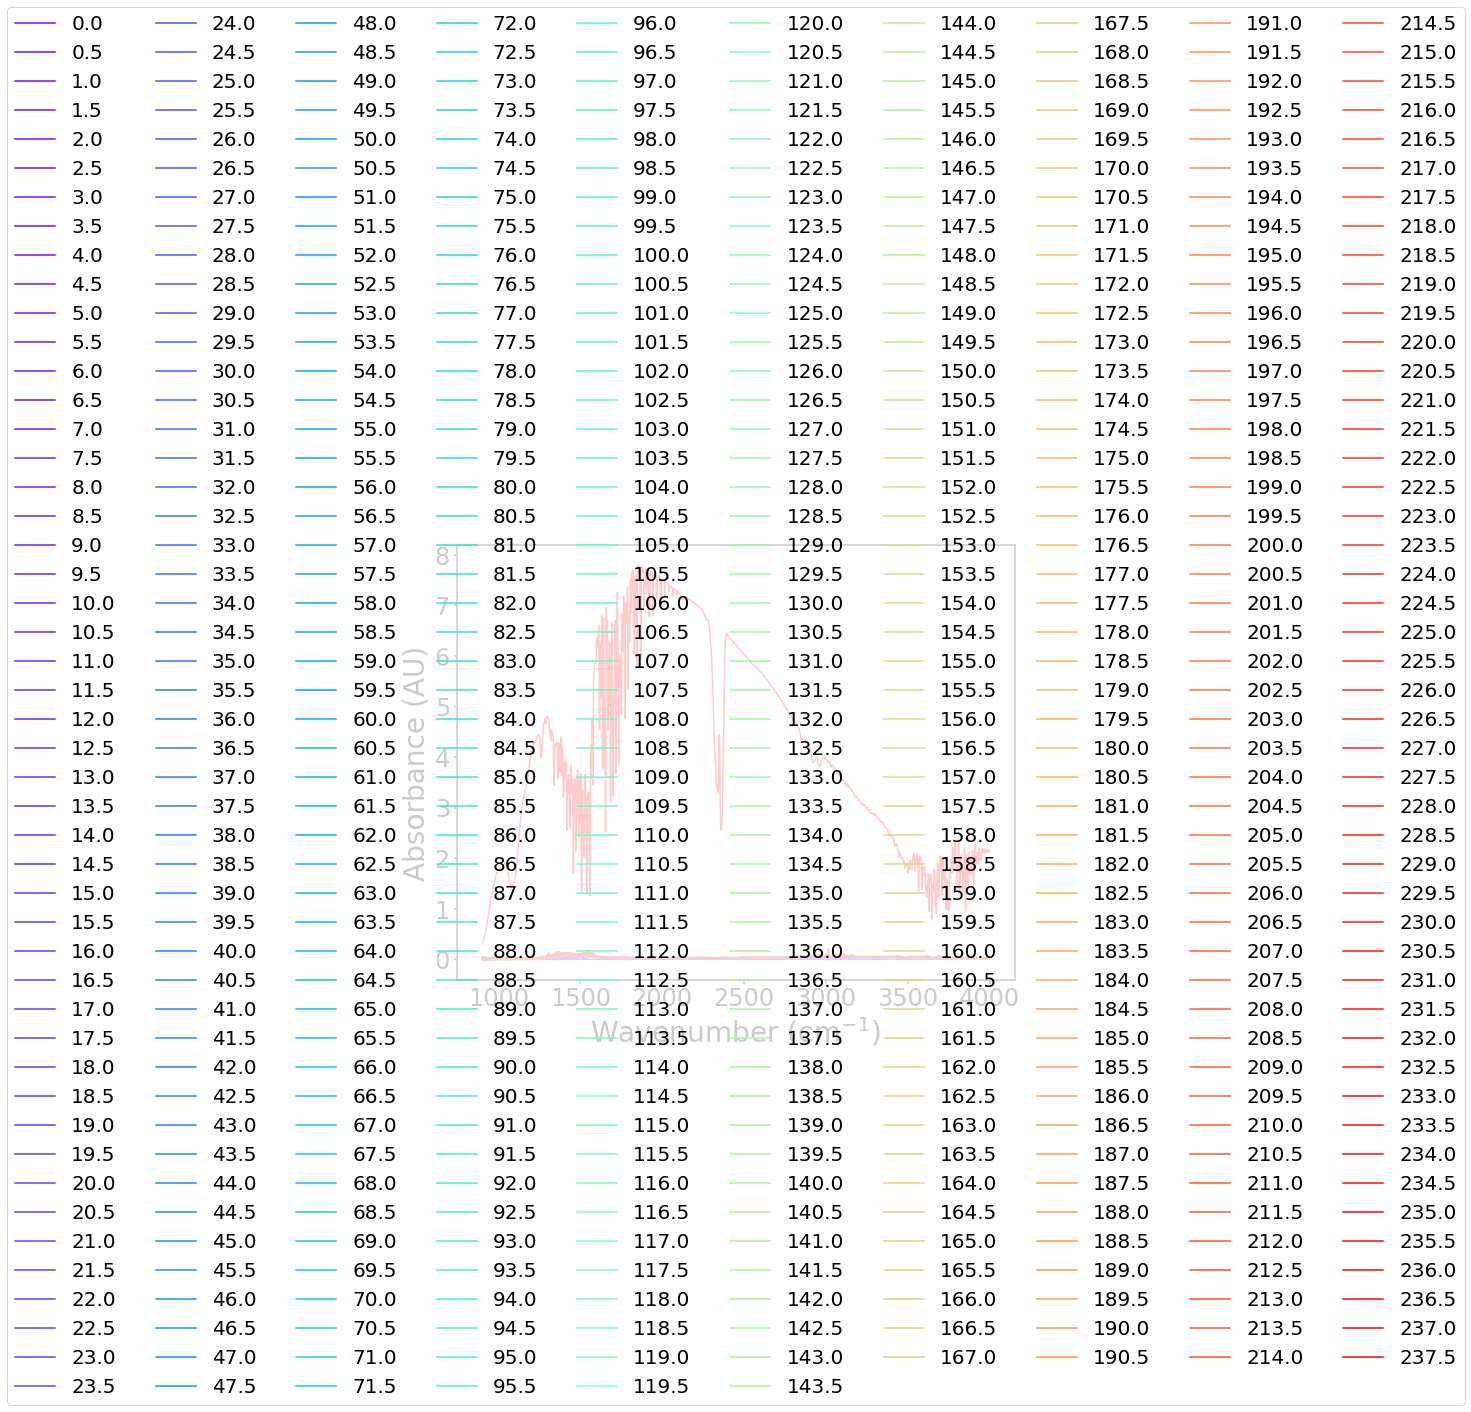

final absorbance array shape:  (476, 6430)


In [11]:
#Rexp(experiment_folder_path, molecule, experiment, sampling, cat_ID, experiment_date, plot = None, subtraction = None):
wn, ab, time = Rexp(path, keyword_file_name, sampling,UOM=unit_of_measure, file_to_subtract=file_to_subtract,\
                    plot=True, subtraction = True, start_T = T_min)

# Gas Contaminant Removal

I found CSV data
/Users/giada/OneDrive - Georgia Institute of Technology/Python_demo/gas_contribution
20210308_gas CH4.CSV
NUMBER OF FILES:  1
It is not possible to set the initial temperature since I have no information on the unit of measure desired
something went wrong, I probably miss the sampling information to build the time array
I sorted your elements this way: 
20210308_gas CH4.CSV
wn shape:  (1, 6762)
I cannot write a legend


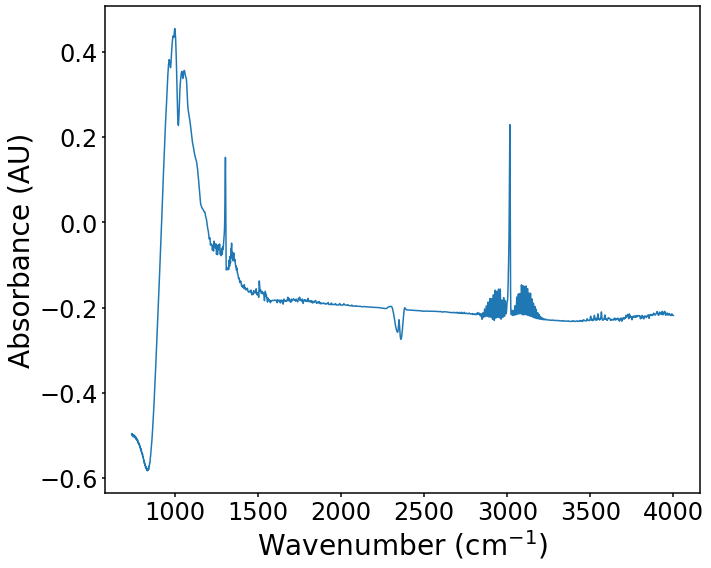

final absorbance array shape:  (1, 6762)


In [12]:
if gas_removal:
    ch4wn, ch4ab, empty = Rexp(gas_spectrum_path, gas_file_name,plot=True)

In [13]:
#cleaning the data from the wavenumbers in a region lower than the windows transmission
try:
    idx_OI = wn_selector(wn,plots_xmin,4000.5)
    wn = wn[:,idx_OI]
    ab=ab[:,idx_OI]
    print('The range of interest was selected')
except:
    print('Your spectra are already in the correct range')


The range of interest was selected


I did not save this image as png


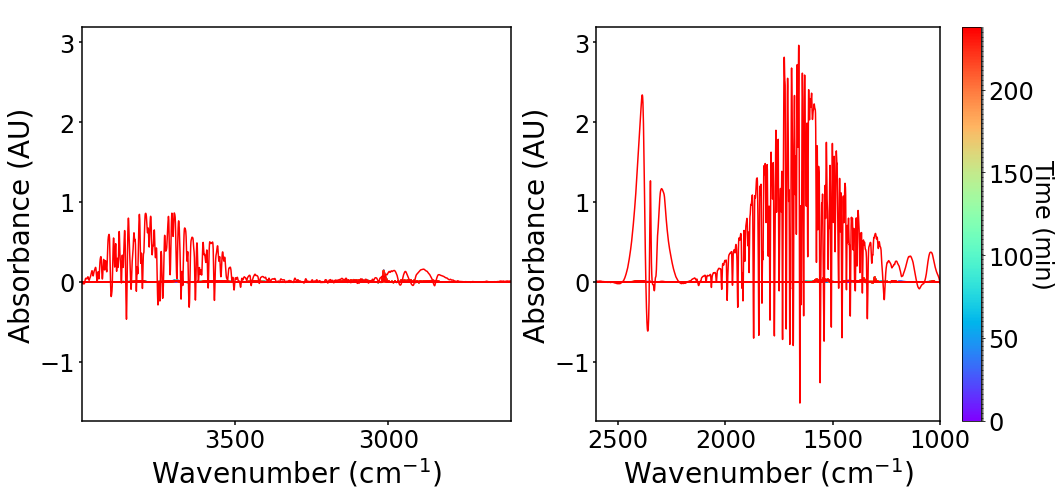

In [14]:
if baseline_removal == True or gas_removal == True:
    baseline_array = np.zeros((np.shape(ab)[0],np.shape(ab)[1]))
    for x, t in enumerate(time):
        baseline_array[x,:] = baseline_als(ab[x,:])
        ab[x,:]=ab[x,:]-baseline_array[x,:]
    FTIR_plot(wn,ab, plots_xmin, 2600, catalyst, time, BARTL = f'{variable_OI} ({unit_of_measure})')

[537]
y_std shape =  (1, 6223)
wn shape =  (476, 6223)
IGW shape = (476, 1)
x_conv = (1, 1244)
ab shape = (476, 1244)
IGW shape = (476, 1)
x_conv = (1, 0)
ab shape = (476, 0)


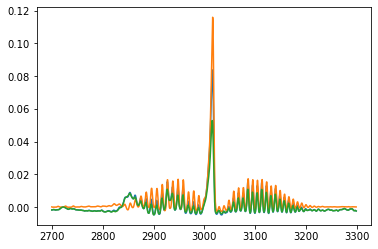

In [15]:
if gas_removal:
    wn,ab,ch4wn,ch4ab=shape_check(wn,ab,ch4wn,ch4ab)
    if perform_MSC:
        ch4ab_ab=np.append(ch4ab,ab,axis=0)
        ch4ab_ab = MSC(ch4ab_ab)
        ch4ab = ch4ab_ab[0,:]
        ch4ab = ch4ab.reshape(1,len(ch4ab))
        ab = ch4ab_ab[1:,:]
    for x in range(np.shape(ch4ab)[0]):
        ch4ab[x,:]=ch4ab[x,:]-baseline_als(ch4ab[x,:])
    if gas_contribution_range:
        for contribution in gas_contribution_range:
            idx_rng = wn_selector(wn,contribution[0],contribution[1])
            plt.plot(wn[100,idx_rng],ab[100,idx_rng])
            plt.plot(ch4wn[0,idx_rng],ch4ab[0,idx_rng])
            plt.plot(ch4wn[0,idx_rng],ab[100,idx_rng]-ch4ab[0,idx_rng]*0.28)
            ab_rng, weights = CH4_removal(wn[:,idx_rng],ab[:,idx_rng],ch4wn[:,idx_rng],ch4ab[:,idx_rng], time, IG=None,\
                         IG_plot=None, plot = visualize_CH4_removal[gas_contribution_range.index(contribution)])
            if weight_CH4_spectra:
                wch4ab = convoluzione(weights, ch4ab)
                ab = ab-wch4ab
                print('weight_CH4_spectra was set to True.')
                print(f'I used the weights retrieved from the region {contribution}.')
                print(f'exiting from the loop...')
                break
            else:
                ab[:,idx_rng] = ab_rng
            
    else:
        if type(visualize_CH4_removal) == list:
            visualize_CH4_removal = visualize_CH4_removal[0] 
        ab,weights = CH4_removal(wn,ab,ch4wn,ch4ab, time, IG=None, IG_plot=None, plot = visualize_CH4_removal)
    

I did not save this image as png


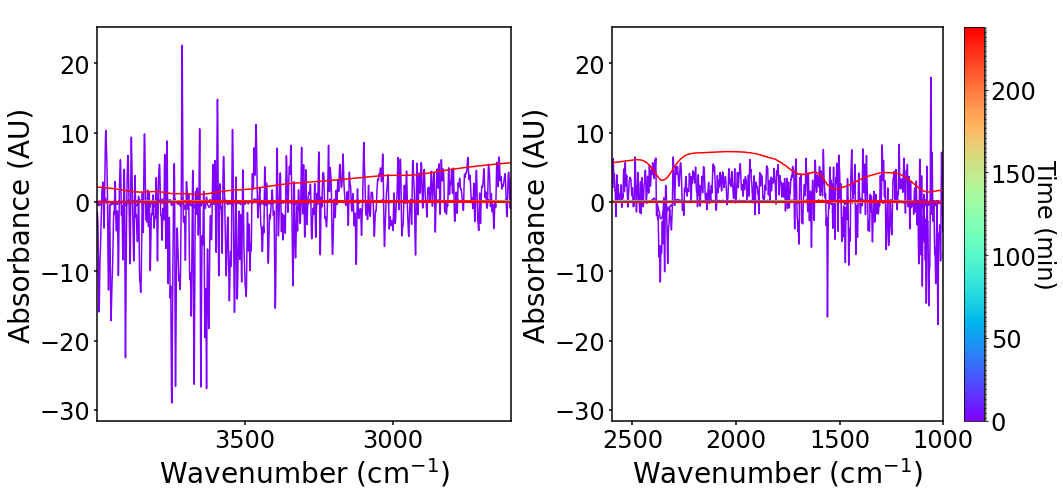

In [16]:
if gas_removal and not baseline_removal:
    for x, t in enumerate(time):
        ab[x,:]=ab[x,:]+baseline_array[x,:]
    FTIR_plot(wn,ab, plots_xmin, 2600, catalyst, time, BARTL = f'{variable_OI} ({unit_of_measure})')
elif gas_removal and baseline_removal:
    FTIR_plot(wn,ab, plots_xmin, 2600, catalyst, time, BARTL = f'{variable_OI} ({unit_of_measure})')

In [17]:
if shift_on_zero:
    for x, t in enumerate(time):
        print(ab[x,wn_selector(wn,2500,2520)[0]])
        ab[x,:]=ab[x,:]-ab[x,wn_selector(wn,2500,2501)[0]]

In [18]:
# printing the time
print(f'{variable_OI} array in {unit_of_measure}:')
if unit_of_measure.casefold() == 'c':
    unit_of_measure = '$^\circ$C'
print(time)

Time array in min:
[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5  11.   11.5
  12.   12.5  13.   13.5  14.   14.5  15.   15.5  16.   16.5  17.   17.5
  18.   18.5  19.   19.5  20.   20.5  21.   21.5  22.   22.5  23.   23.5
  24.   24.5  25.   25.5  26.   26.5  27.   27.5  28.   28.5  29.   29.5
  30.   30.5  31.   31.5  32.   32.5  33.   33.5  34.   34.5  35.   35.5
  36.   36.5  37.   37.5  38.   38.5  39.   39.5  40.   40.5  41.   41.5
  42.   42.5  43.   43.5  44.   44.5  45.   45.5  46.   46.5  47.   47.5
  48.   48.5  49.   49.5  50.   50.5  51.   51.5  52.   52.5  53.   53.5
  54.   54.5  55.   55.5  56.   56.5  57.   57.5  58.   58.5  59.   59.5
  60.   60.5  61.   61.5  62.   62.5  63.   63.5  64.   64.5  65.   65.5
  66.   66.5  67.   67.5  68.   68.5  69.   69.5  70.   70.5  71.   71.5
  72.   72.5  73.   73.5  74.   74.5  75.   75.5  76.   76.5  77.   77.5
  78.   78.5  79.   79.5  80.   

I did not save this image as png


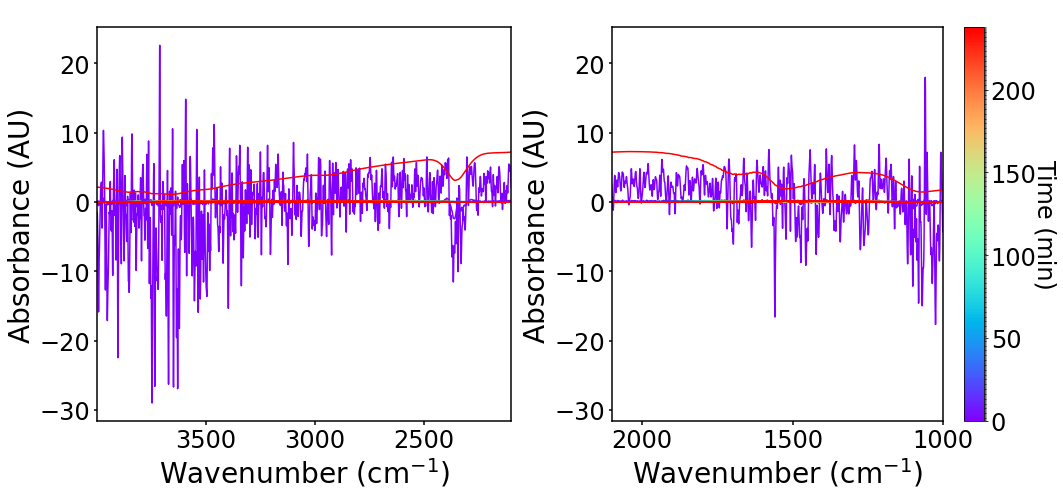

In [19]:
############PLOTTING THE DATA AFTER REMOVING THE CATALYST SURFACE###############
#FTIR_plot(W,A, X0, X1, TLT, T, BARTL = None, ylegend = None, figname=None,
#   y_min = None, y_max = None, X2 = None, X3 = None, text_height_p2=None, 
#    text_height_p1=None, text_alignment_p1=None,text_alignment_p2=None,
#    wn_peaks_df=None,ab_peaks_df=None):
if interactive_plots:
     %matplotlib notebook
        
if variable_OI.casefold() == 'temperature':
    FTIR_plot(wn,ab, plots_xmin, 2500, catalyst, time, BARTL = None, ylegend = None, figname=None, \
              y_min=None, y_max=None, X2 = None, X3 = None)
else:    
    FTIR_plot(wn,ab, plots_xmin, 2100, catalyst, time, BARTL = f'{variable_OI} ({unit_of_measure})',\
              figname=None, y_min=None, y_max=None, X2 = None, X3 = None)


In [20]:
%matplotlib inline
if remove_outliers == 'true'.casefold() or remove_outliers == True:
    ab, wn, time = outlier_removal(ab, wn, time, stdv_value=stdv_value, print_stdv_list = True)
    FTIR_plot(wn,ab, plots_xmin, 2500, catalyst, time, BARTL = f'{variable_OI} ({unit_of_measure})')

# Peak Finder
-- it relies on scipy.signals.find_peaks --
1. find the peaks on the base of the spectrum possessing the highest number of peaks
2. starting from those peaks it optimizes the positions of eack peak for each spectrum at each termperature/time
3. it plots the trends for the intensity and the wavenumber change
4. it allows to save those trends
5. it is possible to plot the peak position as a label on the plot.


In [21]:
if peak_finder or peak_intensity:  
    #find_peak_intensity(absorbance, distance=resolution, height_threshold=None, prominence=None, width=None, rel_height=None)
    # finding the maxima for each spectrum
    Ipeak = []
    index = []
    Itime = []
    Wtime = []
    len_index = 0
    
    for x,t in enumerate(time):
        Ipeak += [find_peak_intensity(ab[x,:],height_threshold=peak_height_threshold, prominence=peak_prominence, width=peakwidth, rel_height=peak_rel_height)]
        # saving the index from the spectrum with the most peaks
        if len(Ipeak[x]) > len_index:
            len_index = len(Ipeak[x])
            index = Ipeak[x]
        opt_peak = []
        for peak_index in index:
            opt_peak += [max_abs_finder(ab[x,:],peak_index, wn[x,:])]  
        Itime += [ab[x,opt_peak]]
        Wtime += [wn[x,opt_peak]]

    Wtime = pd.DataFrame(Wtime)
    Itime = pd.DataFrame(Itime)
#FTIR_plot(W,A, X0, X1, TLT, T, BARTL = None, ylegend = None, figname=None,
#   y_min = None, y_max = None, X2 = None, X3 = None, text_height_p2=None, 
#    text_height_p1=None, text_alignment_p1=None,text_alignment_p2=None,
#    wn_peaks_df=None,ab_peaks_df=None):
    FTIR_plot(wn,ab,plots_xmin,2100,catalyst, time, wn_peaks_df=Wtime,ab_peaks_df=Itime)  


In [22]:
if peak_finder:
    if show_peak_trends:
        %matplotlib inline
        from matplotlib.ticker import StrMethodFormatter

        for x in Wtime.columns:
                fig,(ax1,ax2)= plt.subplots(1,2, figsize = (10,5))

                plt.setp(ax1.spines.values(), linewidth=1.5)
                plt.setp(ax2.spines.values(), linewidth=1.5)

                plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))    
                #plotting the intensity with respect to the time
                ax1.plot(time,Itime[x], ls = ' ', marker = 'o', label = str(np.int(Wtime[x].mean())))
                ax1.set_xlabel('Time ('+unit_of_measure+')', fontsize=(28))
                ax1.set_ylabel('Intensity (AU)', fontsize=(28))
                ax1.legend(fontsize=(20))
                ax1.tick_params(labelsize=26)
                ax1.xaxis.set_tick_params(width=1.5)
                ax1.yaxis.set_tick_params(width=1.5)
                #ax1.axes.ticklabel_format(axis='both', style='sci', scilimits =(1, 100))
                #plotting the wavenumber with respect to the time
                ax2.plot(time, Wtime[x], ls = 'none', marker = '*', color = 'red')
                ax2.set_xlabel(f'{variable_OI} ({unit_of_measure})',fontsize=(28))
                ax2.set_ylabel('Wavenumber (cm$^{-1}$)',fontsize=(28))
                ax2.tick_params(labelsize=20)
                #ax2.set_ylim(Wtime[0,i]-0.2,Wtime[0,i]+0.2)
                #ax2.axes.ticklabel_format(axis='both', style='sci', scilimits =(1, 100))
                ax2.xaxis.set_tick_params(width=1.5)
                ax2.yaxis.set_tick_params(width=1.5)

                plt.tight_layout()
                    #plt.savefig(str(np.int(Wtime[0,i]))+'_'+date+'_'+catalyst+' '+stage+'.png')



In [23]:
if peak_finder and save_peak_trends:
    col_range1 = []
    col_range2 = []
    for index,col in enumerate(Wtime.columns):
        wavenumber = Wtime[Wtime[index]!= np.nan].median()
        if save_peak_trends:
            df = pd.DataFrame({f'{variable_OI} ({unit_of_measure})': time, 'Absorbance':Itime[index]})
            df.to_csv(f"{wavenumber[index]}_intensity_trend_with_respect_to_time.csv", index=False)
        if (wavenumber[index] > 1000 and wavenumber[index] < 2500.):
                col_range1 += [col] 
        elif (wavenumber[index] >2500 and wavenumber[index] <3300):
                col_range2 += [col] 
    plot_time_trends(time,Itime.loc[:,col_range1],Wtime.loc[:,col_range1],\
                     xlabel = f'{variable_OI} ({unit_of_measure})',ylabel="Intensity (AU)",line = line,\
                     marker=marker, smooth=smoothed_trends)
    plot_time_trends(time,Itime.loc[:,col_range2],Wtime.loc[:,col_range2],\
                     xlabel = f'{variable_OI} ({unit_of_measure})',ylabel="Intensity (AU)",line = line,\
                     marker=marker, smooth=smoothed_trends)




In [24]:
if peak_finder:
    if show_label_plot:
        if interactive_plots:
             %matplotlib notebook
    #FTIR_plot(W,A, X0, X1, TLT, T, BARTL = None, ylegend = None, figname=None,
    #   y_min = None, y_max = None, X2 = None, X3 = None, text_height_p2=None, 
    #    text_height_p1=None, text_alignment_p1=None,text_alignment_p2=None,
    #    wn_peaks_df=None,ab_peaks_df=None):    
        FTIR_plot(wn, ab, plots_xmin, 2200, catalyst, time,\
                      BARTL = f'{variable_OI} ({unit_of_measure})', text_height_p1=height1,\
                      text_alignment_p1=align1, text_height_p2=height2,\
                      text_alignment_p2=align2,wn_peaks_df=Wtime,\
                       X2=2600, X3=4000)# y_min = 0.0,y_max = 0.4,

# Subtractions

In [25]:
if subtraction:
    if interactive_plots:
         %matplotlib notebook
    #subtract_one_spectrum(absorbance, wavenumber, subtrahend, minuends, timeframe, \
    #x_min = 1600, x_max = 1800, y_min = None, y_max = None)
    try:
        ab_sub, wn_idx = subtract_one_spectrum(ab, wn, time_base, time_list , time,x_min=plots_xmin,\
                                           x_max=None, y_min=None ,y_max =None)
    except:
        print('Something went wrong in this cell! this will not affect the rest of the script')

In [26]:
if save_subtraction_csv and subtraction:
    try:
        ab_sub=np.array(ab_sub)
        for x in range(np.size(ab_sub,0)):
            df = pd.DataFrame({'Wavenumber': wn[wn_idx[x],:], 'Absorbance':ab_sub[x,:]})
            df.to_csv(f"subtraction_of_{variable_OI}_{time_base}_from_{time_list[x]}.CSV", index=False, header=False)
    except:
        print('something went wrong... Most likely there was a problem with the previous cell')

# 1$^{st}$ and 2$^{nd}$ derivative of the spectra

In [27]:
if show_derivatives_preview:
    %matplotlib inline
    for x,t in enumerate(time):
        fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8))
        ax[0].plot(wn[x,:], ab[x,:], '-', label = 'absorbance')
        ax[1].plot(wn[x,:],savgol_filter(ab[x,:], window_length=9, polyorder=2, deriv=2),'-g', label = 'second derivative')
        ax[1].plot(wn[x,:],savgol_filter(ab[x,:], window_length=9, polyorder=2, deriv=1),'-b', label = 'first derivative', alpha=0.5)
        ax[0].set_xlim(fit_wn_max,fit_wn_min)
        ax[1].set_xlim(fit_wn_max,fit_wn_min)
        ax[0].set_title(f"Spectrum at time {t} {unit_of_measure}")
        ax[1].set_title("1$^{st}$ and 2$^{nd}$ derivative")
        ax[1].hlines(y=0.,xmin=fit_wn_min,xmax =fit_wn_max,linestyles = 'dashed', color = 'black')
        ax[1].legend()
        plt.show()

# Peak Fitting
##### still working on:
1. improving the first and second derivative tests. Sometimes it is still missing the points where both 1st and 2nd derivatives are zero and/or the minima. It loses points that it is able to find when it switch back to the normal data sample size.



In [28]:
if peak_deconvolution:
    tol = [fit_wn_min, fit_wn_max]
    # wn_selector(wavenumbers,wn_min,wn_max)
    fit_idx = wn_selector(wn, fit_wn_min, fit_wn_max)
    wn_fit = wn[:,fit_idx]
    ab_fit = ab[:,fit_idx]

    skip = 0
    peak_dict = {}
    user_decision = True
    # find the derivative with the first and second derivative tests and eventually with the user check
    if user_check and not derivative_peak_finder:
        derivative_peak_finder = user_answer(input('User check is on, Do you want to set on also the derivative evaluation?'))
    print(f"STARTED AT {datetime.now()}")
    if derivative_peak_finder:
        for x, t in enumerate(time[skip:]):
            if t == 0 or user_decision == True:
                wn_peaks = peak_finder_derivative(wn_fit[x+skip,:],ab_fit[x+skip,:],\
                                            tol,fit_wns=[fit_wn_min,fit_wn_max],plot_title=f'Time = {t} {unit_of_measure}',user_interaction=user_check)
            user_check, user_decision = user_interactive_mode(user_check,user_decision, t)
            peak_dict[t] = wn_peaks
    # the user decides all the peaks
    elif user_full_control:
        peak_string = input('Can you give me a list of wavenumbers for my initial guesses (give me as many as the gaussian you want to fit)? [#1,#2,#3, ...]')
        peak_list = string_to_float(peak_string)

        for t in time:
            peak_dict[t]= peak_list
    # use the peak intensity retrieved using scipy
    elif peak_intensity:
        for x, t in enumerate(time):
            peaks = []
            for y in Wtime.columns:
                if Wtime[y].median() < wn_fit[x,-1] and Wtime[y].median() > wn_fit[x,0]: 
                    peaks.append(Wtime[y].median())
            peak_dict[t] = peaks
    else:
        print('I am not sure of how you want to retrieve the peak center, please select an option between derivative_peak_finder, user_full_control or peak_intensity')
    print(f"FINISHED AT {datetime.now()}")

In [29]:
if peak_deconvolution:
    #def peak_fitting(wavenumber, absorbance, peaks, peak_shape=None, baseline_type=None):
    # wavenumber: range of wavenumbers to perform the peak fitting
    # absorbance: experimental absorbance of the IR spectrum
    # peaks: list containing the curve center to perform the fit
    # peak_shape : user_defined function, if none the program will use a pseudo-voight function
    # baseline_type: user_defined function, in None the program will use an exponential baseline
    # peak_center_min: value that will be removed to the peak center to reach the minimum position allowed
    # peak_center_max: value that will be added to the peak center to reach the maximum position allowed
    # if peak_center_min and peak_center_max are both none the value that will be removed and/or added is resolution*4
    # area_min = minimum value allowed for the area - if none is set to 0 
    # area_max = maximum value allowed for the area - if non is set to 1000 
    # sigma_min = minimum value allowed for the characteristic width of the curve, if none is set to 4 
    # sigma_max = maximum value allowed for the characteristic width of the curve, if none is set to 60
    fit_dict = {}
    time_counter = 0 #redefining the global variable here so that every time this cell is run, 
    #it will start from zero again or at least, I think
    print(f'STARTING THE DECONVOLUTION FOR EACH SPECTRA AT {datetime.now()}')
    for x, t in enumerate(time):
        areas, peak_positions = peak_fitting(wn_fit[x,:], ab_fit[x,:], peak_dict[t], peak_shape=peak_shape,\
                                             baseline_type=baseline_type, peak_center_min = peak_center_min,\
                                             peak_center_max = peak_center_max, area_min = area_min,\
                                             area_max = area_max, sigma_min = sigma_min, sigma_max = sigma_max,\
                                             variable_OI= variable_OI, time_list=time,UOM = unit_of_measure)
        fit_dict[t] = { 'Integration': areas,
                     'Positions':peak_positions}
    print(f'PEAK FITTING PROCEDURE FINISHED FOR ALL THE SPECTRA AT {datetime.now()}')

In [30]:
if peak_deconvolution:
    fit_df = from_dict_to_df(fit_dict,time)
    number_peaks = int(len(fit_df.columns)/2)
    fit_df = fit_df.reset_index().rename(columns={'index':variable_OI})
    #plotting the area trends with respect to the time
    c_area_list =[]
    c_wn_list = []
    for x in range(number_peaks):
        c_wn_list += ["Peak"+str(x)]
        c_area_list += ["Area"+str(x)]
    #plot_time_trends(time,ab_df,wn_label,ylabel=None,line = None, 
    #                 marker = None, smooth=None,ab_label=None, figname = None):    
    plot_time_trends(fit_df[f'{variable_OI}'],fit_df.loc[:,c_area_list],fit_df.loc[:,c_wn_list],\
                     xlabel = f'{variable_OI} ({unit_of_measure})',ylabel="Area (cm$^{-1}$)",line = line, marker=marker, smooth=smoothed_trends,\
                     ab_label = c_area_list)

In [31]:
if peak_deconvolution:
    print(fit_df.head(20))

In [32]:
if save_fit_output and peak_deconvolution:
    #save the dictionary 
    dt = datetime.now().strftime("%Y_%m_%d-%I%M%S_%p")
    #save the dataframe
    fit_df.to_csv("fit_df_{:.0f}_{:.0f}_{}.csv".format(fit_wn_min, fit_wn_max, dt))
    
    with open("fit_dic_{:.0f}_{:.0f}_{}.json".format(fit_wn_min, fit_wn_max,dt), "w") as outfile: 
        json.dump(fit_dict, outfile)
   

# Phase Sensitive Detection - Modulation Excitation Spectroscopy

In [33]:
if MES_PSD:
    if remove_loops: 
        spectra_to_remove = int(time_per_period/time_per_scan)
        A = np.delete(ab, range(0,spectra_to_remove),axis=0).T
    else:
        A = ab
    W = wn.mean(axis=0).ravel()
    number_wavelengths,number_scans=A.shape

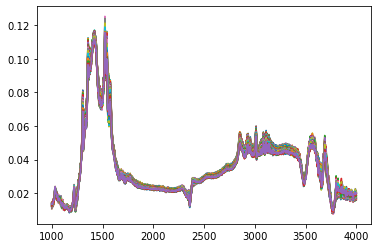

In [34]:
if MES_PSD:
    A_kv=period_average(A,
        time_per_period=time_per_period,
        time_per_scan=time_per_scan)
    
    number_wavelengths,number_scans=A_kv.shape
    for itera in range(0,number_scans):
        plt.plot(W,A_kv[:,itera])

In [35]:
if MES_PSD:
    #phase sensitive detection transform
    A_psd=psd_transform(A_kv)[...,0]
    

[0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5]


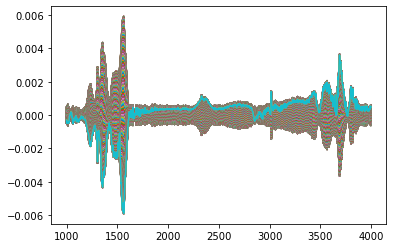

In [36]:
if MES_PSD:
    number_scans,number_wavelength=A_psd.shape
    for itera in range(0,number_scans):
        plt.plot(W,A_psd[itera,:])

range(1, 11)
Approximating by 10 components


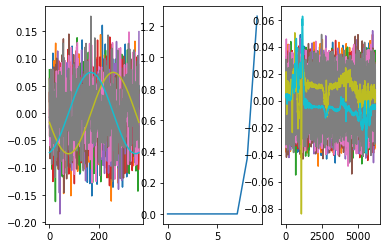

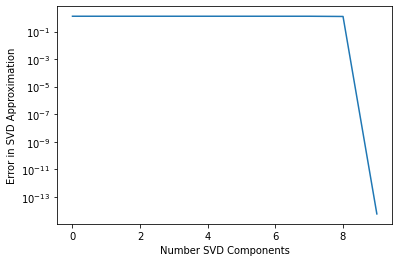

(10, 6223)
(10, 6223)


In [37]:
if MES_PSD:
    #singular value decomposition
    svd,l=SVD(A_psd,k_range=range(1,int(max_components)+1))
    k_range = range(0,len(l))

    if number_components in ['calculate','']:
        i=np.argmin(np.array(l)>error_tolerance)+1 # by default, argmin returns the first
    else:
        i=int(number_components)

    print("Approximating by {0} components".format(i))

    if plot_SVD_vectors == True:
        fig,axs=plt.subplots(nrows=1,ncols=3)
        axs[0].plot(svd[0])
        axs[1].plot(svd[1])
        axs[2].plot(svd[2].T)
        plt.show()
    if plot_SVD_error == True:
        plt.figure()
        plt.xlabel('Number SVD Components')
        plt.ylabel('Error in SVD Approximation')
        plt.semilogy(k_range,l)
        plt.show()

    u,s,vt=svd
    print(np.shape(vt))
    ST_guess=vt[:i]
    print(np.shape(ST_guess))




In [38]:
if MES_PSD:
    mcrar = MCR_fit(A_psd,ST_guess,c_l,st_l, max_iter)

Iter: 1 (C)	mse: 1.4325e-35
Error increased above fractional tol_increase (ST iter). Exiting


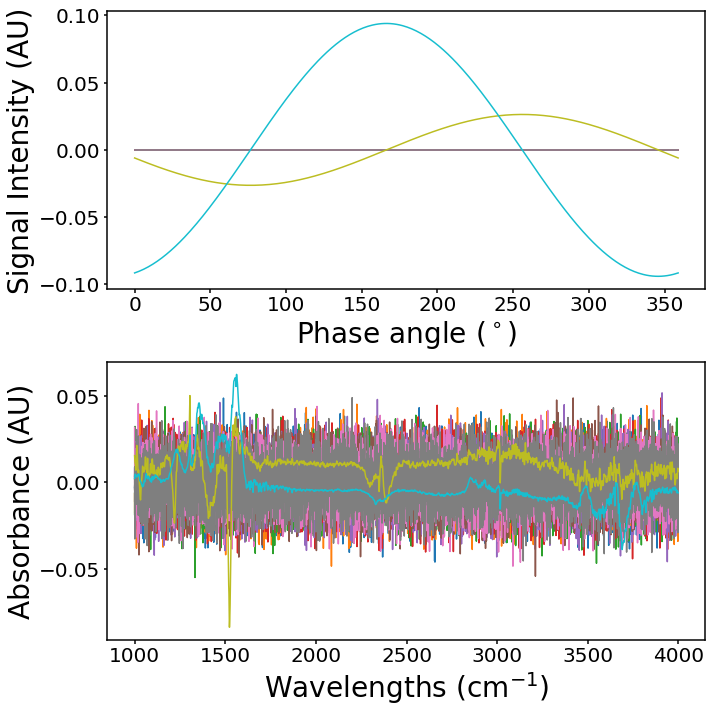

In [39]:
if MES_PSD:
    np.savetxt('wavelengths.txt',W)
    np.savetxt('C-opt.txt',mcrar.C_opt_)

    S=mcrar.ST_opt_.T
    np.savetxt('S-opt.txt',S)

    if plot_MCR_ALS_results == True:
        fig = plt.figure(figsize=(10,10))
        ax1 = plt.subplot(211)
        plt.plot(mcrar.C_opt_)
        plt.setp(ax1.spines.values(), linewidth=1.5)
        plt.xlabel('Phase angle ($^\circ$)',fontsize=(28))
        plt.ylabel('Signal Intensity (AU)',fontsize=(28))
        ax1.axes.tick_params(width = 1.5,labelsize=20)
        ax2 = plt.subplot(212)
        plt.setp(ax2.spines.values(), linewidth=1.5)
        plt.xlabel('Wavelengths (cm$^{-1}$)',fontsize=(28))
        plt.ylabel('Absorbance (AU)',fontsize=(28))
        ax2.axes.tick_params(width = 1.5,labelsize=20)
        plt.plot(W,S)
        plt.tight_layout()
        plt.show()

